In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
nltk.download('punkt_tab')  # This line is only needed the first time you run the code
nltk.download('stopwords') # This line is only needed the first time you run the code

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lopezgg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lopezgg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data loading

In [2]:
data_dir = "../../data/cancer_type"

In [3]:
df_cancer_type = pd.read_csv(
    os.path.join(data_dir, "tcga-tumor-types.csv"),
    sep=";",
    header=0
)
dict_cancer_type = dict(zip(df_cancer_type["Study Abbreviation"].values, df_cancer_type["Study Name"].values))

## Training

In [4]:
df_train = pd.read_csv(
    os.path.join(data_dir, "train_tcga_reports_cancer_type.csv"),
    sep=',',
    header=0
)

In [5]:
df_train.shape

(4761, 4)

In [6]:
arr_train_corpus = df_train["text"].values.tolist()
arr_train_labels = df_train["cancer_type"].values.tolist()

In [7]:
len(arr_train_corpus), len(arr_train_labels)

(4761, 4761)

In [8]:
len(set(arr_train_labels))

32

## Validation

In [9]:
df_val = pd.read_csv(
    os.path.join(data_dir, "val_tcga_reports_cancer_type.csv"),
    sep=',',
    header=0
)

In [10]:
df_val.shape

(1905, 4)

In [11]:
arr_val_corpus = df_val["text"].values.tolist()
arr_val_labels = df_val["cancer_type"].values.tolist()

In [12]:
len(arr_val_corpus), len(arr_val_labels)

(1905, 1905)

In [13]:
len(set(arr_val_labels))

32

# BoW

In [14]:
arr_stopwords = nltk.corpus.stopwords.words('english')

In [15]:
def tokenizer(text):
    """
    Tokenizes the input text (lowercased) using NLTK's word_tokenize function and removes
    stopwords, punctuation, tokens containing non-alphabetic characters, and tokens with length 1.
    
    Args:
        text (str): The input text to tokenize.
        
    Returns:
        list: A list of tokens.
    """
    arr_tokens = word_tokenize(text.lower())
    # Remove tokens with length 1
    arr_tokens = [token for token in arr_tokens if len(token) > 1]
    # Remove stopwords
    arr_tokens = [token for token in arr_tokens if token not in arr_stopwords]
    # Remove punctuation and tokens containing non-alphabetic characters
    arr_tokens = [token for token in arr_tokens if token.isalpha()]
    return arr_tokens

In [16]:
word_vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    token_pattern=None,
    lowercase=False,
    stop_words=None
)

Fit the BoW model on the training set:

In [17]:
word_vectorizer.fit(arr_train_corpus)

CountVectorizer(lowercase=False, token_pattern=None,
                tokenizer=<function tokenizer at 0x1b255e340>)

In [18]:
# Vocabulary size
len(word_vectorizer.vocabulary_)

23818

In [19]:
dict_index_word = {value: key for key, value in word_vectorizer.vocabulary_.items()}

Transform the training set using the fitted BoW mdoel:

In [20]:
arr_train_bow = word_vectorizer.transform(arr_train_corpus)

In [21]:
arr_train_bow.shape

(4761, 23818)

In [22]:
pd.Series(np.array(arr_train_bow.sum(axis=0))[0]).describe()

count    23818.000000
mean        68.057939
std        711.776370
min          1.000000
25%          1.000000
50%          1.000000
75%          6.000000
max      45522.000000
dtype: float64

Transform the validation set using the fitted BoW mdoel:

In [23]:
arr_val_bow = word_vectorizer.transform(arr_val_corpus)

In [24]:
arr_val_bow.shape

(1905, 23818)

# Cancer type classification

## Random Forest

In [25]:
clf = RandomForestClassifier(
    random_state=0,
    n_estimators=100
)

### Training

In [26]:
clf.fit(
    X=arr_train_bow,
    y=arr_train_labels,
)

RandomForestClassifier(random_state=0)

### Evaluation

#### Train set

In [27]:
arr_train_pred = clf.predict(
    X=arr_train_bow
)

In [28]:
accuracy_score(
    y_true=arr_train_labels,
    y_pred=arr_train_pred
)

0.9995799201848351

In [29]:
print(classification_report(
    y_true=arr_train_labels,
    y_pred=arr_train_pred
))

              precision    recall  f1-score   support

         ACC       1.00      1.00      1.00        42
        BLCA       1.00      1.00      1.00       180
        BRCA       1.00      1.00      1.00       532
        CESC       1.00      1.00      1.00       155
        CHOL       1.00      1.00      1.00        21
        COAD       1.00      1.00      1.00       213
        DLBC       1.00      1.00      1.00        23
        ESCA       1.00      1.00      1.00        82
         GBM       1.00      1.00      1.00       184
        HNSC       1.00      1.00      1.00       254
        KICH       1.00      1.00      1.00        54
        KIRC       1.00      1.00      1.00       255
        KIRP       1.00      1.00      1.00       143
         LGG       1.00      1.00      1.00       230
        LIHC       1.00      1.00      1.00       183
        LUAD       1.00      1.00      1.00       230
        LUSC       1.00      1.00      1.00       232
        MESO       1.00    

#### Validation set

In [30]:
arr_val_pred = clf.predict(
    X=arr_val_bow
)

In [31]:
accuracy_score(
    y_true=arr_val_labels,
    y_pred=arr_val_pred
)

0.9139107611548556

In [32]:
print(classification_report(
    y_true=arr_val_labels,
    y_pred=arr_val_pred
))

              precision    recall  f1-score   support

         ACC       1.00      0.62      0.77        16
        BLCA       0.99      0.96      0.97        70
        BRCA       0.98      1.00      0.99       232
        CESC       0.95      0.80      0.87        45
        CHOL       1.00      0.44      0.62         9
        COAD       0.78      0.95      0.86        85
        DLBC       1.00      0.62      0.77         8
        ESCA       0.92      0.86      0.89        28
         GBM       0.94      0.94      0.94        80
        HNSC       0.99      1.00      1.00       118
        KICH       1.00      0.05      0.10        19
        KIRC       0.75      0.99      0.85       111
        KIRP       0.95      0.71      0.81        55
         LGG       0.91      0.97      0.94       103
        LIHC       0.92      1.00      0.96        56
        LUAD       0.89      0.90      0.90       104
        LUSC       0.88      0.92      0.90        97
        MESO       1.00    

/Users/lopezgg/miniconda3/envs/ai-campus/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lopezgg/miniconda3/envs/ai-campus/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lopezgg/miniconda3/envs/ai-campus/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### Performance for each cancer type

In [33]:
arr_val_f1_label = f1_score(
    y_true=arr_val_labels,
    y_pred=arr_val_pred,
    average=None,
    labels=clf.classes_
)

In [34]:
arr_res = []
for i in range(len(clf.classes_)):
    label = clf.classes_[i]
    f1 = arr_val_f1_label[i]
    n_train = len(df_train[df_train["cancer_type"] == label])
    n_val = len(df_val[df_val["cancer_type"] == label])
    arr_res.append({
        "label": label,
        "f1": f1,
        "n_train": n_train,
        "n_val": n_val
    })
df_val_f1_label = pd.DataFrame(arr_res)


In [35]:
df_val_f1_label.sort_values(
    by="f1",
    ascending=True
)

,label,f1,n_train,n_val
30,UCS,0.000000,29,8
10,KICH,0.100000,54,19
22,READ,0.478261,84,31
4,CHOL,0.615385,21,9
0,ACC,0.769231,42,16
6,DLBC,0.769231,23,8
12,KIRP,0.812500,143,55
23,SARC,0.837838,125,43
11,KIRC,0.852713,255,111
24,SKCM,0.857143,47,16


### Feature importance

In [36]:
clf.feature_importances_.shape

(23818,)

In [37]:
def plot_top_words(coefficients, dict_index_word, top_n=10):
    # Get the top N indices
    top_indices = np.argsort(coefficients)[-top_n:]
    top_words = [dict_index_word[idx] for idx in top_indices]
    top_values = coefficients[top_indices]

    # Plot the top words
    plt.figure(figsize=(10, 5))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel("Coefficient Value")
    plt.ylabel("Words")
    plt.title(f"Top {top_n} Words by Coefficient Value")
    plt.show()

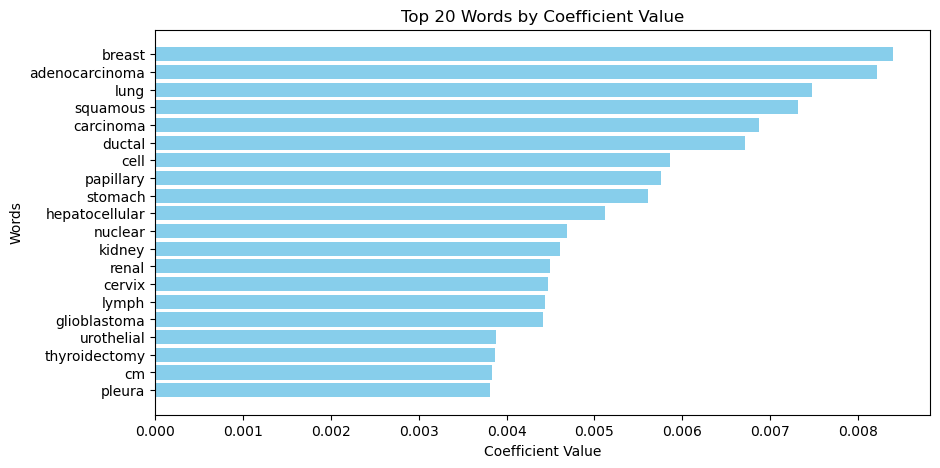

In [38]:
plot_top_words(
    coefficients=clf.feature_importances_,
    dict_index_word=dict_index_word,
    top_n=20
)